In [2]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import datasets,decomposition,manifold
import sklearn.neighbors as nb
import struct
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline


In [3]:
def load_mnist_training(num):
    print("training data loading")
    original_data_file = open('train-images',"rb")
    label_file = open('train-labels',"rb")
    data_buff = original_data_file.read()
    label_buff = label_file.read()

    data_index = 0
    label_index = 0

    # read the magic, image numbers, rows, columns
    magicD, numImages , numRows , numColumns = struct.unpack_from('>IIII' , data_buff , data_index)
    data_index += struct.calcsize('>IIII')

    magicL, numLabels = struct.unpack_from('>II' , label_buff , label_index)    
    label_index += struct.calcsize('>II') 

    data = np.zeros((num,28*28))
    labels = []

    for i in range(num):
        # read data
        im = struct.unpack_from('>784B',data_buff, data_index)
        data_index += struct.calcsize('>784B')
        im = np.mat(im)
        data[i]=im

        #read labels
        la = struct.unpack_from('>1B',label_buff, label_index)   
        label = la[0] 
        label_index += struct.calcsize('>1B')  
        labels.append(label) 
        
    print("training data loaded")
    return data, labels

In [4]:
def load_mnist_testing(num):
    print("testing data loading")
    original_data_file = open('t10k-images',"rb")
    label_file = open('t10k-labels',"rb")
    data_buff = original_data_file.read()
    label_buff = label_file.read()

    data_index = 0
    label_index = 0

    # read the magic, image numbers, rows, columns
    magicD, numImages , numRows , numColumns = struct.unpack_from('>IIII' , data_buff , data_index)
    data_index += struct.calcsize('>IIII')

    magicL, numLabels = struct.unpack_from('>II' , label_buff , label_index)    
    label_index += struct.calcsize('>II') 


    testdata = np.zeros((num,28*28))
    testlabels = []

    for i in range(num):
        # read data
        im = struct.unpack_from('>784B',data_buff, data_index)
        data_index += struct.calcsize('>784B')
        im = np.mat(im)
        testdata[i]=im

        #read labels
        la = struct.unpack_from('>1B',label_buff, label_index)   
        label = la[0] 
        label_index += struct.calcsize('>1B')  
        testlabels.append(label) 
    print("testing data loaded")
    return testdata, testlabels


In [5]:
def LLE(data, k, d):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    print("data dimensional reducing")
    print("computing weights")
    data = np.matrix(data)
   
    N = data.shape[0]
    D = data.shape[1]
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    
    sort_index = np.argsort(distance,axis=1)

    # k nearest neibors
    neibors = sort_index[:,1:k+1]

    # step 2
    # weights
    
    W = np.zeros((N, N))
    
    # Gram Matrix
    
    if(k > D):
        add = 0.001
    else:
        add = 0
    
    for i in range(N):
        neibors_i = neibors[i].A[0]
        G = data[neibors_i[:]] - data[i] 
        G = G * G.T
        G = G + np.eye(k) * add * np.trace(G)
        G_I = G.I
        w_i = np.sum(G_I,axis=1) / np.sum(G_I)
        w_i = w_i.flatten([0])
    
        for j in neibors_i:
            W[i][j]=w_i[np.where(neibors[i]==j)]
    
    # Step 3
    # M 
    
    print("computing M")
    M=np.eye(N,N) - W
    M=np.dot(M.T, M)
    eig_values, eig_vectors = np.linalg.eig(M)
    
    print("computing eig")
    eig_index = np.argsort(eig_values)
    eig_index = eig_index[1:d+1]
    output = np.mat(eig_vectors[:,eig_index])
    print("reduction done")
    return output



training data loading
training data loaded
data dimensional reducing
computing weights
computing M
computing eig
reduction done
drawing


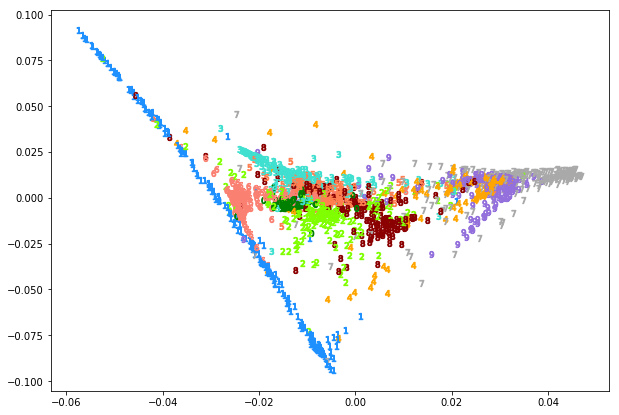

In [9]:
data, labels = load_mnist_training(2000)
low_data= LLE(data, 8, 2)

print("drawing")
fig = plt.figure(figsize=(10,7))
plotwindow = fig.add_subplot(111)
a = np.array(low_data)

# draw the scatters
color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
marker = ["$0$","$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$"]
for j in range(len(low_data)):
    plt.scatter(a[j][0], a[j][1],s=40, c=color[labels[j]],marker=marker[labels[j]])
plt.show()

In [14]:
def lle_mnist_knn(n_neighbor, n_dimension, data, labels):

    low_data= LLE(data, n_neighbor, n_dimension)

    print("KNN training")
    knn = nb.KNeighborsClassifier(n_neighbors = 1)  
    knn.fit(low_data[:1000], labels[:1000])

    s = knn.score(low_data[1000:2000], labels[1000:2000])
    print("KNN score",s)
    return s

In [12]:
data, labels = load_mnist_testing(2000)
values=[[0]*21]*21
for k in range(1,21,2):
    for d in range(1,21,2):
        print("k,d",k,d)
        value = lle_mnist_knn(k,d,data,labels)
        values[k][d]=value

testing data loading
testing data loaded
k,d 1 1
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.725
k,d 1 3
data dimensional reducing
computing weights


/Users/killandy/Library/Python/3.6/lib/python/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


computing M
computing eig
reduction done
KNN training
KNN score 0.734
k,d 1 5
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.733
k,d 1 7
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.74
k,d 1 9
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.732
k,d 1 11
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.736
k,d 1 13
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.737
k,d 1 15
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.74
k,d 1 17
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.739
k,d 1 19
data dimensional reducing
computing weights
computing M
computing

computing M
computing eig
reduction done
KNN training
KNN score 0.795
k,d 13 19
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.799
k,d 15 1
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.308
k,d 15 3
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.575
k,d 15 5
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.638
k,d 15 7
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.68
k,d 15 9
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.72
k,d 15 11
data dimensional reducing
computing weights
computing M
computing eig
reduction done
KNN training
KNN score 0.746
k,d 15 13
data dimensional reducing
computing weights
computing M
com

In [13]:
print(values)

[[0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0], [0, None, 0, None, 0, None, 0, None, 0, None, 0, 